# BOB - the Big-Ole-Budget


## compare what comes out of the ATX ATY DTX DTY with DIC_UT DIC_VT

## BUDGET run specs:

    results on graham: /scratch/tjarnik/BUDGET
    results on salish: /data/tjarniko/results/FUTURE_runs/BUDGET/01jan17_RIVTA5/
    /data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/
    run suffix: RIVTA5
    
Equivalence notebook: 

http://localhost:8802/notebooks/notebooks/RIVER_PAPER/BUDGET/equivalence_check-RIVTA_and_PRDREM_METRICS.ipynb
    
   


In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [23]:
import numpy as np
# import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
# from scipy.io import loadmat
from cmocean import cm
import pandas as pd
import warnings
import pickle
import arrow
#from cartopy import crs, feature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools
import netCDF4 as nc
import glob
from decimal import Decimal

#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11
warnings.simplefilter('ignore')


## Start budgeting

Governing source-sink equations of the system (as written in MM16/Jarnikova20whatever):

$\frac{\partial DIC}{\partial t } = - (U_{N} + U_{PC} - Rm_{N}) * R_{C:N} + {physical transport} + {airsea flux} $ 

$\frac{\partial TA}{\partial t } = U_{NO3-} - 2Rm_{NO3-} - U_{NH4+} + Rm_{NH4+} + (U_{PO4} + Rm_{PO4})* R_{N:P} + {physical transport}$ 


Decision i've made: 

    - everything calculated 20 grid cells (10 km) in from boundary


- things we need: 

- carbon content of domain daily (mmol)
            - one way to get that is (daily average DIC) * (e1t*e2t*e3t)
            - one way to get that is through DIC_e3tsnap * (e1t*e2t)
                -instantaneous-at-END-of-day DIC concentration * e3t at that time (changes due to tidal range)
- change in daily carbon content (subtract daily values of the above)

this change should be equal to the sum of the daily totals of:

- river carbon input (RIV_DIC (mmol/s))
- carbon taken up by phytoplankton (mmol/s)
- carbon remineralized (mmol/s)
- carbon going through the western boundary (mmol/s)
- carbon going through the northern boundary (mmol/s)
- carbon going through the air-sea boundary (air_sea_carbon * e1t*e2t, mmol/s)

            

In [24]:
print('hm')

hm


In [25]:
# dimensional conversion variables 

#meshmask
mmk = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
e2t = (mmk['e2t'][0,:,:])
e1t = (mmk['e1t'][0,:,:])
surfar_m2 = e1t * e2t
tmask_orig = mmk['tmask'][0,:,:,:]
tmask = (mmk['tmask'][0,:,:,:])

# cut edges
tmask[:,878:898,0:100] = 0
tmask[:,:,0:20] = 0

surfar_m2[878:898,0:100] = 0
surfar_m2[:,0:20] = 0

surfar_m2_broad = np.zeros([40,898,398])

for i in range(0,40):
    surfar_m2_broad[i,:,:] = surfar_m2

surfar_m2_mask = surfar_m2_broad * tmask

#seconds in day
sid = 60*60*24

### notes and variables for conversion

    sid --- seconds in day, 86400
    surfar_m2_broad --- surface area of cell in m2 * tmask (20 grid cells from left and top edge cut), 40x898x398
    tmask --- 40x898x398 (20 grid cells from left and top edge cut)
    1 m3 = 1e-9 km3

In [26]:
q4 = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/SalishSeaCast_1d_20170101_20170130_advdif_T_20170101-20170101.nc'

w = glob.glob(f'{q4}')
w2 = nc.Dataset(w[0])
print(np.nansum(w2['ATF DIC'][:]))

q4 = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/SalishSeaCast_1d_20170101_20170130_advdif_T_20170110-20170110.nc'

w = glob.glob(f'{q4}')
w2 = nc.Dataset(w[0])
print(np.nansum(w2['ATF DIC'][:]))
w2.variables.keys()

1637.5627
4006.5303


odict_keys(['nav_lat_grid_T', 'nav_lon_grid_T', 'bounds_nav_lon_grid_T', 'bounds_nav_lat_grid_T', 'area_grid_T', 'deptht', 'deptht_bounds', 'nav_lat_grid_U', 'nav_lon_grid_U', 'bounds_nav_lon_grid_U', 'bounds_nav_lat_grid_U', 'area_grid_U', 'depthu', 'depthu_bounds', 'nav_lat_grid_V', 'nav_lon_grid_V', 'bounds_nav_lon_grid_V', 'bounds_nav_lat_grid_V', 'area_grid_V', 'depthv', 'depthv_bounds', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'ATF DIC', 'ATF TA', 'ATX DIC', 'ATX TA', 'DTX DIC', 'DTX TA', 'ATY DIC', 'ATY TA', 'DTY DIC', 'DTY TA'])

#### function to get BOB numbers out, option to print with sci. not. 

In [27]:
daystr = '20170111'
### function to get bob numbers

def find_bob_numbers(daystr, verbose = True, advdif = False):
    
    if advdif:
        q4 = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/'
    else:
        q4 = '/data/tjarniko/results/FUTURE_runs/BUDGET/*_RIVTA5/'
        
    prdrem = glob.glob(f'{q4}*_1d_*_PRDREM_T_{daystr}-{daystr}.nc')
    prdrem_boi = nc.Dataset(prdrem[0])
    carp = glob.glob(f'{q4}*_1d_*_carp_T_{daystr}-{daystr}.nc')
    carp_boi = nc.Dataset(carp[0])
    dianu = glob.glob(f'{q4}*_1d_*_dian_U_{daystr}-{daystr}.nc')
    dianu_boi = nc.Dataset(dianu[0])
    dianv = glob.glob(f'{q4}*_1d_*_dian_V_{daystr}-{daystr}.nc')
    dianv_boi = nc.Dataset(dianv[0])

    e3t = carp_boi['e3t'][0,:,:,:]
    vol_m3 = surfar_m2_mask * e3t 
    vol_km3_tot = np.nansum(vol_m3) * 1e-9
    
    ## TOTAL DIC IN SYSTEM IN MMOLS
    e3t = carp_boi['e3t'][0,:,:,:]
    DIC = carp_boi['dissolved_inorganic_carbon'][0,:,:,:]
    DIC_mmol = DIC * e3t* surfar_m2_mask 
    DIC_mmol_tot = np.nansum(DIC_mmol)

    DIC_SNAP = carp_boi['DIC_E3TSNAP'][0,:,:,:]
    DIC_SNAP_mmol = DIC_SNAP * surfar_m2_mask 
    DIC_SNAP_mmol_tot = np.nansum(DIC_SNAP_mmol)

    #### total DIC input in rivers
    # ?? when multiply river_DIC by tmask, stuff gets cut out? tthere must be a river coming in near the boundary 

    riverine_DIC = prdrem_boi['riverine DIC'][0,:,:,:]  * tmask
    riv_DIC_mmol_day_tot = np.nansum(riverine_DIC) * sid
    
    ### total DIC taken up by production 
    PRD_DIC = prdrem_boi['PRD DIC'][0,:,:,:]  * tmask
    PRD_DIC_mmol_day_tot = np.nansum(PRD_DIC) * sid 

    UNC_DIC = prdrem_boi['Uncoupled DIC uptake'][0,:,:,:]  * tmask
    UNC_DIC_mmol_day_tot = np.nansum(UNC_DIC) * sid * (-1)
    ### total DIC remineralized
    REM_DIC = prdrem_boi['REM DIC'][0,:,:,:]  * tmask
    REM_DIC_mmol_day_tot = np.nansum(REM_DIC) * sid 

    DIC_UT = dianu_boi['DIC_UT'][0,:,:,19] * sid 
    DIC_UT_mmol_day_pos = np.nansum(DIC_UT[DIC_UT>=0])
    DIC_UT_mmol_day_neg = np.nansum(DIC_UT[DIC_UT<=0])
    DIC_UT_mmol_day_tot = np.nansum(DIC_UT) 

    ## this is johnstone strait. negative is INTO DOMAIN
    DIC_VT = dianv_boi['DIC_VT'][0,:,877,0:100] * (-1)  * sid 
    DIC_VT_mmol_day_pos = np.nansum(DIC_VT[DIC_VT>=0])
    DIC_VT_mmol_day_neg = np.nansum(DIC_VT[DIC_VT<=0])
    DIC_VT_mmol_day_tot = np.nansum(DIC_VT)
    
    if advdif: 
    #atx aty
        advdif = glob.glob(f'{q4}*_1d_*_advdif_T_{daystr}-{daystr}.nc')
        advdif_boi = nc.Dataset(advdif[0])

        ATF_DIC = advdif_boi['ATF DIC'][0,:,:,:]  * tmask *sid 
        ATF_DIC_mmol_day_tot = np.nansum(ATF_DIC) 
        
        ATX_DIC = advdif_boi['ATX DIC'][0,:,:,19] * sid 
        ATX_DIC_mmol_day_pos = np.nansum(ATX_DIC[ATX_DIC>=0])
        ATX_DIC_mmol_day_neg = np.nansum(ATX_DIC[ATX_DIC<=0])
        ATX_DIC_mmol_day_tot = np.nansum(ATX_DIC) 
      
        ATY_DIC = advdif_boi['ATY DIC'][0,:,877,0:100] *  (-1) * sid 
        ATY_DIC_mmol_day_pos = np.nansum(ATY_DIC[ATY_DIC>=0])
        ATY_DIC_mmol_day_neg = np.nansum(ATY_DIC[ATY_DIC<=0])
        ATY_DIC_mmol_day_tot = np.nansum(ATY_DIC) 

        DTX_DIC = advdif_boi['DTX DIC'][0,:,:,19] * sid 
        DTX_DIC_mmol_day_pos = np.nansum(DTX_DIC[DTX_DIC>=0])
        DTX_DIC_mmol_day_neg = np.nansum(DTX_DIC[DTX_DIC<=0])
        DTX_DIC_mmol_day_tot = np.nansum(DTX_DIC) 

        DTY_DIC = advdif_boi['DTY DIC'][0,:,877,0:100] * (-1) * sid 
        DTY_DIC_mmol_day_pos = np.nansum(DTY_DIC[DTY_DIC>=0])
        DTY_DIC_mmol_day_neg = np.nansum(DTY_DIC[DTY_DIC<=0])
        DTY_DIC_mmol_day_tot = np.nansum(DTY_DIC) 

        

    ASflux = carp_boi['co2_flux_mmol_m2_s'][0,:,:]
    ASflux_mmol_day_tot = np.nansum(ASflux* surfar_m2_mask[0,:,:]) *sid

    #daychange = 

    if advdif:
        daychange_new = ASflux_mmol_day_tot + \
        ATX_DIC_mmol_day_tot + ATY_DIC_mmol_day_tot + \
        DTX_DIC_mmol_day_tot + DTY_DIC_mmol_day_tot +\
        REM_DIC_mmol_day_tot + PRD_DIC_mmol_day_tot + \
        riv_DIC_mmol_day_tot + ATF_DIC_mmol_day_tot
        
        daychange = ASflux_mmol_day_tot + \
        DIC_VT_mmol_day_tot + DIC_UT_mmol_day_tot + \
        REM_DIC_mmol_day_tot + PRD_DIC_mmol_day_tot + \
        riv_DIC_mmol_day_tot 
    
    else: 
        daychange = ASflux_mmol_day_tot + \
        DIC_VT_mmol_day_tot + DIC_UT_mmol_day_tot + \
        REM_DIC_mmol_day_tot + PRD_DIC_mmol_day_tot + \
        riv_DIC_mmol_day_tot 
    
    
    if verbose:
        print(f'day is {daystr}')
        print('km3 water in system (day average):')
        print(f"{Decimal(vol_km3_tot):.8E}")

        print('')
        print('mmols DIC in system (day average):')
        print(f"{Decimal(DIC_mmol_tot):.8E}")
        print('mmols DIC in system (snapshot at midnight):')
        print(f"{Decimal(DIC_SNAP_mmol_tot):.8E}")

        print('')
        print('DIC coming in through rivers (mmol/day):')
        print(f"{Decimal(riv_DIC_mmol_day_tot):.8E}")

        print('DIC taken up by phyto (mmol/day):')
        print(f"{Decimal(PRD_DIC_mmol_day_tot):.8E}")

        print('UNCOUPLED DIC taken up by phyto (mmol/day):')
        print(f"{Decimal(UNC_DIC_mmol_day_tot):.8E}")

        print('DIC remineralized! (mmol/day):')
        print(f"{Decimal(REM_DIC_mmol_day_tot):.8E}")

        print('DIC through western JDF boundary (+ = in, to the east, mmol/day)')
        print(f"{Decimal(DIC_UT_mmol_day_tot):.8E}")

        print('DIC through northern JS boundary (+ = in, to the south, mmol/day)')
        print(f"{Decimal(DIC_VT_mmol_day_tot):.8E}")

        print('Air-sea flux (+ = in, from air to sea, mmol/day)')
        print(f"{Decimal(ASflux_mmol_day_tot):.8E}")

        print('')
        print('total change in DIC from all sources and sinks today (mmol/day):')
        print(f"{Decimal(daychange):.8E}")
    
    if advdif:
        return vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, daychange_new,\
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg, \
ATX_DIC_mmol_day_tot, ATX_DIC_mmol_day_pos, ATX_DIC_mmol_day_neg, \
ATY_DIC_mmol_day_tot, ATY_DIC_mmol_day_pos, ATY_DIC_mmol_day_neg, \
DTX_DIC_mmol_day_tot, DTX_DIC_mmol_day_pos, DTX_DIC_mmol_day_neg, \
DTY_DIC_mmol_day_tot, DTY_DIC_mmol_day_pos, DTY_DIC_mmol_day_neg, \
ATF_DIC_mmol_day_tot
    
    else:
        return vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, \
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg

print('advdif')
vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, DIC_UT_mmol_day_tot, \
DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, daychange_new,\
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg, \
ATX_DIC_mmol_day_tot, ATX_DIC_mmol_day_pos, ATX_DIC_mmol_day_neg, \
ATY_DIC_mmol_day_tot, ATY_DIC_mmol_day_pos, ATY_DIC_mmol_day_neg, \
DTX_DIC_mmol_day_tot, DTX_DIC_mmol_day_pos, DTX_DIC_mmol_day_neg, \
DTY_DIC_mmol_day_tot, DTY_DIC_mmol_day_pos, DTY_DIC_mmol_day_neg, \
ATF_DIC_mmol_day_tot \
= find_bob_numbers(daystr, verbose = False, advdif = True)
print('standard daychange')
print(daychange)
print('new daychange')
print(daychange_new)
print('UTVT')
vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, \
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg \
= find_bob_numbers(daystr, verbose = False, advdif = False)
print(daychange)
print('DIC_UT_mmol_day_tot')
print(DIC_UT_mmol_day_tot)
print('ATX_DIC_mmol_day_tot')
print(ATX_DIC_mmol_day_tot)
print('DTX_DIC_mmol_day_tot')
print(DTX_DIC_mmol_day_tot)
print()
print('DIC_VT_mmol_day_tot')
print(DIC_VT_mmol_day_tot)
print('ATY_DIC_mmol_day_tot')
print(ATY_DIC_mmol_day_tot)
print('DTY_DIC_mmol_day_tot')
print(DTY_DIC_mmol_day_tot)
print('ATF_DIC_mmol_day_tot')
print(ATF_DIC_mmol_day_tot)

# river carbon input (RIV_DIC (mmol/s))
# carbon taken up by phytoplankton (mmol/s)
# carbon remineralized (mmol/s)
# carbon going through the western boundary (mmol/s)
# carbon going through the northern boundary (mmol/s)
# carbon going through the air-sea boundary (air_sea_carbon * e1t*e2t, mmol/s)

advdif
standard daychange
6546115826286.485
new daychange
6547779147218.474
UTVT
6476785571674.886
DIC_UT_mmol_day_tot
5164468652260.877
ATX_DIC_mmol_day_tot
5242175642197.814
DTX_DIC_mmol_day_tot
-391953539.7675365

DIC_VT_mmol_day_tot
1451429668289.795
ATY_DIC_mmol_day_tot
1444660982583.1375
DTY_DIC_mmol_day_tot
114777799.17610176
ATF_DIC_mmol_day_tot
490133062.4842154


## workhorse bob-getting-cells

In [28]:
# print(dayslen)

In [29]:
#DIC UT cell

start ='2017-01-01'
end ='2017-12-25'
runhorse = True
if runhorse:

    # end ='2017-01-02'


    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)

    vol_km3_tot_ar = np.zeros(dayslen); DIC_mmol_tot_ar = np.zeros(dayslen)
    DIC_SNAP_mmol_tot_ar = np.zeros(dayslen); 
    riv_DIC_mmol_day_tot_ar = np.zeros(dayslen); PRD_DIC_mmol_day_tot_ar = np.zeros(dayslen); 
    UNC_DIC_mmol_day_tot_ar = np.zeros(dayslen); REM_DIC_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
    ASflux_mmol_day_tot_ar = np.zeros(dayslen); daychange_mmol_day_tot_ar = np.zeros(dayslen)
    daychange_new_mmol_day_tot_ar = np.zeros(dayslen)

    
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        print(tdate)
        daystr = tdate.format('YYYYMMDD')

        vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, \
        riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
        UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
        DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, \
        ASflux_mmol_day_tot, daychange_mmol_day_tot,\
        DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
        DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg \
        = find_bob_numbers(daystr, False, advdif = False)

        vol_km3_tot_ar[i] = vol_km3_tot; DIC_mmol_tot_ar[i] = DIC_mmol_tot; 
        DIC_SNAP_mmol_tot_ar[i] = DIC_SNAP_mmol_tot; riv_DIC_mmol_day_tot_ar[i] = riv_DIC_mmol_day_tot;
        PRD_DIC_mmol_day_tot_ar[i] = PRD_DIC_mmol_day_tot; UNC_DIC_mmol_day_tot_ar[i] = UNC_DIC_mmol_day_tot;
        REM_DIC_mmol_day_tot_ar[i] = REM_DIC_mmol_day_tot; DIC_UT_mmol_day_tot_ar[i] = DIC_UT_mmol_day_tot;
        DIC_VT_mmol_day_tot_ar[i] = DIC_VT_mmol_day_tot; ASflux_mmol_day_tot_ar[i] = ASflux_mmol_day_tot;
        daychange_mmol_day_tot_ar[i] = daychange_mmol_day_tot
        DIC_VT_mmol_day_neg_ar[i] = DIC_VT_mmol_day_neg
        DIC_VT_mmol_day_pos_ar[i] = DIC_VT_mmol_day_pos
        DIC_UT_mmol_day_neg_ar[i] = DIC_UT_mmol_day_neg
        DIC_UT_mmol_day_pos_ar[i] = DIC_UT_mmol_day_pos


    fn = f'BUDGETVARS_RIVTA5_{start}-{end}.nc'
    ds = nc.Dataset(fn, 'w', format='NETCDF4')

    days = ds.createDimension('days', dayslen)
    vol_km3_tot_ar_nc = ds.createVariable('vol_km3_tot_ar', 'f4', ('days',))
    vol_km3_tot_ar_nc[:] = vol_km3_tot_ar 
    DIC_mmol_tot_ar_nc = ds.createVariable('DIC_mmol_tot_ar', 'f4', ('days',))
    DIC_mmol_tot_ar_nc[:] = DIC_mmol_tot_ar 
    DIC_SNAP_mmol_tot_ar_nc = ds.createVariable('DIC_SNAP_mmol_tot_ar', 'f4', ('days',))
    DIC_SNAP_mmol_tot_ar_nc[:] = DIC_SNAP_mmol_tot_ar 
    riv_DIC_mmol_day_tot_ar_nc = ds.createVariable('riv_DIC_mmol_day_tot_ar', 'f4', ('days',))
    riv_DIC_mmol_day_tot_ar_nc[:] = riv_DIC_mmol_day_tot_ar 
    PRD_DIC_mmol_day_tot_ar_nc = ds.createVariable('PRD_DIC_mmol_day_tot_ar', 'f4', ('days',))
    PRD_DIC_mmol_day_tot_ar_nc[:] = PRD_DIC_mmol_day_tot_ar 
    UNC_DIC_mmol_day_tot_ar_nc = ds.createVariable('UNC_DIC_mmol_day_tot_ar', 'f4', ('days',))
    UNC_DIC_mmol_day_tot_ar_nc[:] = UNC_DIC_mmol_day_tot_ar 
    REM_DIC_mmol_day_tot_ar_nc = ds.createVariable('REM_DIC_mmol_day_tot_ar', 'f4', ('days',))
    REM_DIC_mmol_day_tot_ar_nc[:] = REM_DIC_mmol_day_tot_ar 
    DIC_UT_mmol_day_tot_ar_nc = ds.createVariable('DIC_UT_mmol_day_tot_ar', 'f4', ('days',))
    DIC_UT_mmol_day_tot_ar_nc[:] = DIC_UT_mmol_day_tot_ar 
    DIC_VT_mmol_day_tot_ar_nc = ds.createVariable('DIC_VT_mmol_day_tot_ar', 'f4', ('days',))
    DIC_VT_mmol_day_tot_ar_nc[:] = DIC_VT_mmol_day_tot_ar 
    ASflux_mmol_day_tot_ar_nc = ds.createVariable('ASflux_mmol_day_tot_ar', 'f4', ('days',))
    ASflux_mmol_day_tot_ar_nc[:] = ASflux_mmol_day_tot_ar 
    daychange_mmol_day_tot_ar_nc = ds.createVariable('daychange_mmol_day_tot_ar', 'f4', ('days',))
    daychange_mmol_day_tot_ar_nc[:] = daychange_mmol_day_tot_ar 
    DIC_VT_mmol_day_pos_ar_nc = ds.createVariable('DIC_VT_mmol_day_pos_ar', 'f4', ('days',))
    DIC_VT_mmol_day_pos_ar_nc[:] = DIC_VT_mmol_day_pos_ar 
    DIC_VT_mmol_day_neg_ar_nc = ds.createVariable('DIC_VT_mmol_day_neg_ar', 'f4', ('days',))
    DIC_VT_mmol_day_neg_ar_nc[:] = DIC_VT_mmol_day_neg_ar 
    DIC_UT_mmol_day_pos_ar_nc = ds.createVariable('DIC_UT_mmol_day_pos_ar', 'f4', ('days',))
    DIC_UT_mmol_day_pos_ar_nc[:] = DIC_UT_mmol_day_pos_ar 
    DIC_UT_mmol_day_neg_ar_nc = ds.createVariable('DIC_UT_mmol_day_neg_ar', 'f4', ('days',))
    DIC_UT_mmol_day_neg_ar_nc[:] = DIC_UT_mmol_day_neg_ar 


    ds.close()
    
else: 
    print('no running of extraction')

2017-01-01T00:00:00+00:00
2017-01-02T00:00:00+00:00
2017-01-03T00:00:00+00:00
2017-01-04T00:00:00+00:00
2017-01-05T00:00:00+00:00
2017-01-06T00:00:00+00:00
2017-01-07T00:00:00+00:00
2017-01-08T00:00:00+00:00
2017-01-09T00:00:00+00:00
2017-01-10T00:00:00+00:00
2017-01-11T00:00:00+00:00
2017-01-12T00:00:00+00:00
2017-01-13T00:00:00+00:00
2017-01-14T00:00:00+00:00
2017-01-15T00:00:00+00:00
2017-01-16T00:00:00+00:00
2017-01-17T00:00:00+00:00
2017-01-18T00:00:00+00:00
2017-01-19T00:00:00+00:00
2017-01-20T00:00:00+00:00
2017-01-21T00:00:00+00:00
2017-01-22T00:00:00+00:00
2017-01-23T00:00:00+00:00
2017-01-24T00:00:00+00:00
2017-01-25T00:00:00+00:00
2017-01-26T00:00:00+00:00
2017-01-27T00:00:00+00:00
2017-01-28T00:00:00+00:00
2017-01-29T00:00:00+00:00
2017-01-30T00:00:00+00:00
2017-01-31T00:00:00+00:00
2017-02-01T00:00:00+00:00
2017-02-02T00:00:00+00:00
2017-02-03T00:00:00+00:00
2017-02-04T00:00:00+00:00
2017-02-05T00:00:00+00:00
2017-02-06T00:00:00+00:00
2017-02-07T00:00:00+00:00
2017-02-08T0

2017-11-13T00:00:00+00:00
2017-11-14T00:00:00+00:00
2017-11-15T00:00:00+00:00
2017-11-16T00:00:00+00:00
2017-11-17T00:00:00+00:00
2017-11-18T00:00:00+00:00
2017-11-19T00:00:00+00:00
2017-11-20T00:00:00+00:00
2017-11-21T00:00:00+00:00
2017-11-22T00:00:00+00:00
2017-11-23T00:00:00+00:00
2017-11-24T00:00:00+00:00
2017-11-25T00:00:00+00:00
2017-11-26T00:00:00+00:00
2017-11-27T00:00:00+00:00
2017-11-28T00:00:00+00:00
2017-11-29T00:00:00+00:00
2017-11-30T00:00:00+00:00
2017-12-01T00:00:00+00:00
2017-12-02T00:00:00+00:00
2017-12-03T00:00:00+00:00
2017-12-04T00:00:00+00:00
2017-12-05T00:00:00+00:00
2017-12-06T00:00:00+00:00
2017-12-07T00:00:00+00:00
2017-12-08T00:00:00+00:00
2017-12-09T00:00:00+00:00
2017-12-10T00:00:00+00:00
2017-12-11T00:00:00+00:00
2017-12-12T00:00:00+00:00
2017-12-13T00:00:00+00:00
2017-12-14T00:00:00+00:00
2017-12-15T00:00:00+00:00
2017-12-16T00:00:00+00:00
2017-12-17T00:00:00+00:00
2017-12-18T00:00:00+00:00
2017-12-19T00:00:00+00:00
2017-12-20T00:00:00+00:00
2017-12-21T0

In [30]:
#DIC advdif cell
runhorse = True

if runhorse:

    # end ='2017-01-02'


    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)

    vol_km3_tot_ar = np.zeros(dayslen); DIC_mmol_tot_ar = np.zeros(dayslen)
    DIC_SNAP_mmol_tot_ar = np.zeros(dayslen); 
    daychange_new_mmol_day_tot_ar = np.zeros(dayslen); 
    riv_DIC_mmol_day_tot_ar = np.zeros(dayslen); PRD_DIC_mmol_day_tot_ar = np.zeros(dayslen); 
    UNC_DIC_mmol_day_tot_ar = np.zeros(dayslen); REM_DIC_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
    ASflux_mmol_day_tot_ar = np.zeros(dayslen); daychange_mmol_day_tot_ar = np.zeros(dayslen)

    DIC_ATX_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_ATX_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_ATX_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
    
    DIC_ATY_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_ATY_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_ATY_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 

    DIC_DTX_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_DTX_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_DTX_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
    
    DIC_DTY_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_DTY_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_DTY_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
 
    DIC_ATF_mmol_day_tot_ar = np.zeros(dayslen);
    
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        print(tdate)
        daystr = tdate.format('YYYYMMDD')

        vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, \
        riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
        UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
        DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, \
        ASflux_mmol_day_tot, daychange_mmol_day_tot, daychange_new_mmol_day_tot,\
        DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
        DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg, \
        ATX_DIC_mmol_day_tot, ATX_DIC_mmol_day_pos, ATX_DIC_mmol_day_neg, \
        ATY_DIC_mmol_day_tot, ATY_DIC_mmol_day_pos, ATY_DIC_mmol_day_neg, \
        DTX_DIC_mmol_day_tot, DTX_DIC_mmol_day_pos, DTX_DIC_mmol_day_neg, \
        DTY_DIC_mmol_day_tot, DTY_DIC_mmol_day_pos, DTY_DIC_mmol_day_neg, \
        DIC_ATF_mmol_day_tot\
        = find_bob_numbers(daystr, False, advdif = True)

        vol_km3_tot_ar[i] = vol_km3_tot; DIC_mmol_tot_ar[i] = DIC_mmol_tot; 
        DIC_SNAP_mmol_tot_ar[i] = DIC_SNAP_mmol_tot; riv_DIC_mmol_day_tot_ar[i] = riv_DIC_mmol_day_tot;
        PRD_DIC_mmol_day_tot_ar[i] = PRD_DIC_mmol_day_tot; UNC_DIC_mmol_day_tot_ar[i] = UNC_DIC_mmol_day_tot;
        REM_DIC_mmol_day_tot_ar[i] = REM_DIC_mmol_day_tot; DIC_UT_mmol_day_tot_ar[i] = DIC_UT_mmol_day_tot;
        DIC_VT_mmol_day_tot_ar[i] = DIC_VT_mmol_day_tot; ASflux_mmol_day_tot_ar[i] = ASflux_mmol_day_tot;
        daychange_mmol_day_tot_ar[i] = daychange_mmol_day_tot
        DIC_VT_mmol_day_neg_ar[i] = DIC_VT_mmol_day_neg
        DIC_VT_mmol_day_pos_ar[i] = DIC_VT_mmol_day_pos
        DIC_UT_mmol_day_neg_ar[i] = DIC_UT_mmol_day_neg
        DIC_UT_mmol_day_pos_ar[i] = DIC_UT_mmol_day_pos
        
        DIC_ATF_mmol_day_tot_ar[i] = DIC_ATF_mmol_day_tot;
        print(DIC_ATF_mmol_day_tot)
        DIC_ATX_mmol_day_tot_ar[i] = ATX_DIC_mmol_day_tot;
        DIC_DTX_mmol_day_tot_ar[i] = DTX_DIC_mmol_day_tot;
        DIC_ATY_mmol_day_tot_ar[i] = ATY_DIC_mmol_day_tot;
        DIC_DTY_mmol_day_tot_ar[i] = DTY_DIC_mmol_day_tot;
        
        DIC_ATX_mmol_day_pos_ar[i] = ATX_DIC_mmol_day_pos;
        DIC_DTX_mmol_day_pos_ar[i] = DTX_DIC_mmol_day_pos;
        DIC_ATY_mmol_day_pos_ar[i] = ATY_DIC_mmol_day_pos;
        DIC_DTY_mmol_day_pos_ar[i] = DTY_DIC_mmol_day_pos;

        DIC_ATX_mmol_day_neg_ar[i] = ATX_DIC_mmol_day_neg;
        DIC_DTX_mmol_day_neg_ar[i] = DTX_DIC_mmol_day_neg;
        DIC_ATY_mmol_day_neg_ar[i] = ATY_DIC_mmol_day_neg;
        DIC_DTY_mmol_day_neg_ar[i] = DTY_DIC_mmol_day_neg;    
        daychange_new_mmol_day_tot_ar[i] = daychange_new_mmol_day_tot;
        
    fn = f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc'
    ds = nc.Dataset(fn, 'w', format='NETCDF4')

    days = ds.createDimension('days', dayslen)
    vol_km3_tot_ar_nc = ds.createVariable('vol_km3_tot_ar', 'f4', ('days',))
    vol_km3_tot_ar_nc[:] = vol_km3_tot_ar 
    DIC_mmol_tot_ar_nc = ds.createVariable('DIC_mmol_tot_ar', 'f4', ('days',))
    DIC_mmol_tot_ar_nc[:] = DIC_mmol_tot_ar 
    DIC_SNAP_mmol_tot_ar_nc = ds.createVariable('DIC_SNAP_mmol_tot_ar', 'f4', ('days',))
    DIC_SNAP_mmol_tot_ar_nc[:] = DIC_SNAP_mmol_tot_ar 
    riv_DIC_mmol_day_tot_ar_nc = ds.createVariable('riv_DIC_mmol_day_tot_ar', 'f4', ('days',))
    riv_DIC_mmol_day_tot_ar_nc[:] = riv_DIC_mmol_day_tot_ar 
    PRD_DIC_mmol_day_tot_ar_nc = ds.createVariable('PRD_DIC_mmol_day_tot_ar', 'f4', ('days',))
    PRD_DIC_mmol_day_tot_ar_nc[:] = PRD_DIC_mmol_day_tot_ar 
    UNC_DIC_mmol_day_tot_ar_nc = ds.createVariable('UNC_DIC_mmol_day_tot_ar', 'f4', ('days',))
    UNC_DIC_mmol_day_tot_ar_nc[:] = UNC_DIC_mmol_day_tot_ar 
    REM_DIC_mmol_day_tot_ar_nc = ds.createVariable('REM_DIC_mmol_day_tot_ar', 'f4', ('days',))
    REM_DIC_mmol_day_tot_ar_nc[:] = REM_DIC_mmol_day_tot_ar 
    DIC_UT_mmol_day_tot_ar_nc = ds.createVariable('DIC_UT_mmol_day_tot_ar', 'f4', ('days',))
    DIC_UT_mmol_day_tot_ar_nc[:] = DIC_UT_mmol_day_tot_ar 
    DIC_VT_mmol_day_tot_ar_nc = ds.createVariable('DIC_VT_mmol_day_tot_ar', 'f4', ('days',))
    DIC_VT_mmol_day_tot_ar_nc[:] = DIC_VT_mmol_day_tot_ar 
    ASflux_mmol_day_tot_ar_nc = ds.createVariable('ASflux_mmol_day_tot_ar', 'f4', ('days',))
    ASflux_mmol_day_tot_ar_nc[:] = ASflux_mmol_day_tot_ar 
    daychange_mmol_day_tot_ar_nc = ds.createVariable('daychange_mmol_day_tot_ar', 'f4', ('days',))
    daychange_mmol_day_tot_ar_nc[:] = daychange_mmol_day_tot_ar 
    DIC_VT_mmol_day_pos_ar_nc = ds.createVariable('DIC_VT_mmol_day_pos_ar', 'f4', ('days',))
    DIC_VT_mmol_day_pos_ar_nc[:] = DIC_VT_mmol_day_pos_ar 
    DIC_VT_mmol_day_neg_ar_nc = ds.createVariable('DIC_VT_mmol_day_neg_ar', 'f4', ('days',))
    DIC_VT_mmol_day_neg_ar_nc[:] = DIC_VT_mmol_day_neg_ar 
    DIC_UT_mmol_day_pos_ar_nc = ds.createVariable('DIC_UT_mmol_day_pos_ar', 'f4', ('days',))
    DIC_UT_mmol_day_pos_ar_nc[:] = DIC_UT_mmol_day_pos_ar 
    DIC_UT_mmol_day_neg_ar_nc = ds.createVariable('DIC_UT_mmol_day_neg_ar', 'f4', ('days',))
    DIC_UT_mmol_day_neg_ar_nc[:] = DIC_UT_mmol_day_neg_ar 

    DIC_ATX_mmol_day_pos_ar_nc = ds.createVariable('DIC_ATX_mmol_day_pos_ar', 'f4', ('days',))
    DIC_ATX_mmol_day_pos_ar_nc[:] = DIC_ATX_mmol_day_pos_ar 
    DIC_ATX_mmol_day_neg_ar_nc = ds.createVariable('DIC_ATX_mmol_day_neg_ar', 'f4', ('days',))
    DIC_ATX_mmol_day_neg_ar_nc[:] = DIC_ATX_mmol_day_neg_ar 

    DIC_ATY_mmol_day_pos_ar_nc = ds.createVariable('DIC_ATY_mmol_day_pos_ar', 'f4', ('days',))
    DIC_ATY_mmol_day_pos_ar_nc[:] = DIC_ATY_mmol_day_pos_ar 
    DIC_ATY_mmol_day_neg_ar_nc = ds.createVariable('DIC_ATY_mmol_day_neg_ar', 'f4', ('days',))
    DIC_ATY_mmol_day_neg_ar_nc[:] = DIC_ATY_mmol_day_neg_ar 

    DIC_DTX_mmol_day_pos_ar_nc = ds.createVariable('DIC_DTX_mmol_day_pos_ar', 'f4', ('days',))
    DIC_DTX_mmol_day_pos_ar_nc[:] = DIC_DTX_mmol_day_pos_ar 
    DIC_DTX_mmol_day_neg_ar_nc = ds.createVariable('DIC_DTX_mmol_day_neg_ar', 'f4', ('days',))
    DIC_DTX_mmol_day_neg_ar_nc[:] = DIC_DTX_mmol_day_neg_ar 

    DIC_DTY_mmol_day_pos_ar_nc = ds.createVariable('DIC_DTY_mmol_day_pos_ar', 'f4', ('days',))
    DIC_DTY_mmol_day_pos_ar_nc[:] = DIC_DTY_mmol_day_pos_ar 
    DIC_DTY_mmol_day_neg_ar_nc = ds.createVariable('DIC_DTY_mmol_day_neg_ar', 'f4', ('days',))
    DIC_DTY_mmol_day_neg_ar_nc[:] = DIC_DTY_mmol_day_neg_ar 
    
    DIC_ATF_mmol_day_tot_ar_nc = ds.createVariable('DIC_ATF_mmol_day_tot_ar', 'f4', ('days',))
    DIC_ATF_mmol_day_tot_ar_nc[:] = DIC_ATF_mmol_day_tot_ar 

    daychange_new_mmol_day_tot_ar_nc = ds.createVariable('daychange_new_mmol_day_tot_ar', 'f4', ('days',))
    daychange_new_mmol_day_tot_ar_nc[:] = daychange_new_mmol_day_tot_ar 

#             DIC_ATF_mmol_day_tot_ar[i] = DIC_ATF_mmol_day_tot;
#         DIC_ATX_mmol_day_tot_ar[i] = DIC_ATX_mmol_day_tot;
#         DIC_DTX_mmol_day_tot_ar[i] = DIC_DTX_mmol_day_tot;
#         DIC_ATY_mmol_day_tot_ar[i] = DIC_ATY_mmol_day_tot;
#         DIC_DTY_mmol_day_tot_ar[i] = DIC_DTY_mmol_day_tot;
        
#         DIC_ATX_mmol_day_pos_ar[i] = DIC_ATX_mmol_day_pos;
#         DIC_DTX_mmol_day_pos_ar[i] = DIC_DTX_mmol_day_pos;
#         DIC_ATY_mmol_day_pos_ar[i] = DIC_ATY_mmol_day_pos;
#         DIC_DTY_mmol_day_pos_ar[i] = DIC_DTY_mmol_day_pos;

#         DIC_ATX_mmol_day_neg_ar[i] = DIC_ATX_mmol_day_neg;
#         DIC_DTX_mmol_day_neg_ar[i] = DIC_DTX_mmol_day_neg;
#         DIC_ATY_mmol_day_neg_ar[i] = DIC_ATY_mmol_day_neg;
#         DIC_DTY_mmol_day_neg_ar[i] = DIC_DTY_mmol_day_neg;  
    

    ds.close()
    
else: 
    print('no running of extraction')

2017-01-01T00:00:00+00:00
155207249.50555253
2017-01-02T00:00:00+00:00
111327542.61890033
2017-01-03T00:00:00+00:00
-56126862.96099898
2017-01-04T00:00:00+00:00
-210131300.78812227
2017-01-05T00:00:00+00:00
-224512104.7229378
2017-01-06T00:00:00+00:00
-244897009.15968773
2017-01-07T00:00:00+00:00
-104787835.85818556
2017-01-08T00:00:00+00:00
64933059.05640817
2017-01-09T00:00:00+00:00
163715259.40437308
2017-01-10T00:00:00+00:00
332403694.77641666
2017-01-11T00:00:00+00:00
490133062.4842154
2017-01-12T00:00:00+00:00
436676204.8615571
2017-01-13T00:00:00+00:00
360535245.59494245
2017-01-14T00:00:00+00:00
261112405.12426817
2017-01-15T00:00:00+00:00
105181293.2972157
2017-01-16T00:00:00+00:00
-17048585.331054647
2017-01-17T00:00:00+00:00
-136671093.14659983
2017-01-18T00:00:00+00:00
-154068295.19036976
2017-01-19T00:00:00+00:00
-62631294.116253845
2017-01-20T00:00:00+00:00
-39786696.19252921
2017-01-21T00:00:00+00:00
-41967096.29650433
2017-01-22T00:00:00+00:00
-2386319.3780723135
2017-0

-129381882.84669259
2017-07-03T00:00:00+00:00
105278474.08292814
2017-07-04T00:00:00+00:00
297664180.7477541
2017-07-05T00:00:00+00:00
394472464.08859783
2017-07-06T00:00:00+00:00
393969844.9261004
2017-07-07T00:00:00+00:00
337746522.49541324
2017-07-08T00:00:00+00:00
323600685.7453362
2017-07-09T00:00:00+00:00
222217580.32758123
2017-07-10T00:00:00+00:00
168840819.99303317
2017-07-11T00:00:00+00:00
52499697.67317529
2017-07-12T00:00:00+00:00
-59133629.39520947
2017-07-13T00:00:00+00:00
-181654681.60953522
2017-07-14T00:00:00+00:00
-284039749.102732
2017-07-15T00:00:00+00:00
-438140239.1101861
2017-07-16T00:00:00+00:00
-446906818.28922206
2017-07-17T00:00:00+00:00
-302466728.2480494
2017-07-18T00:00:00+00:00
-77048363.52765554
2017-07-19T00:00:00+00:00
217664678.5836928
2017-07-20T00:00:00+00:00
460419119.59784395
2017-07-21T00:00:00+00:00
699765826.8289133
2017-07-22T00:00:00+00:00
599851234.8563346
2017-07-23T00:00:00+00:00
485971146.5308957
2017-07-24T00:00:00+00:00
325215894.804940

No handles with labels found to put in legend.


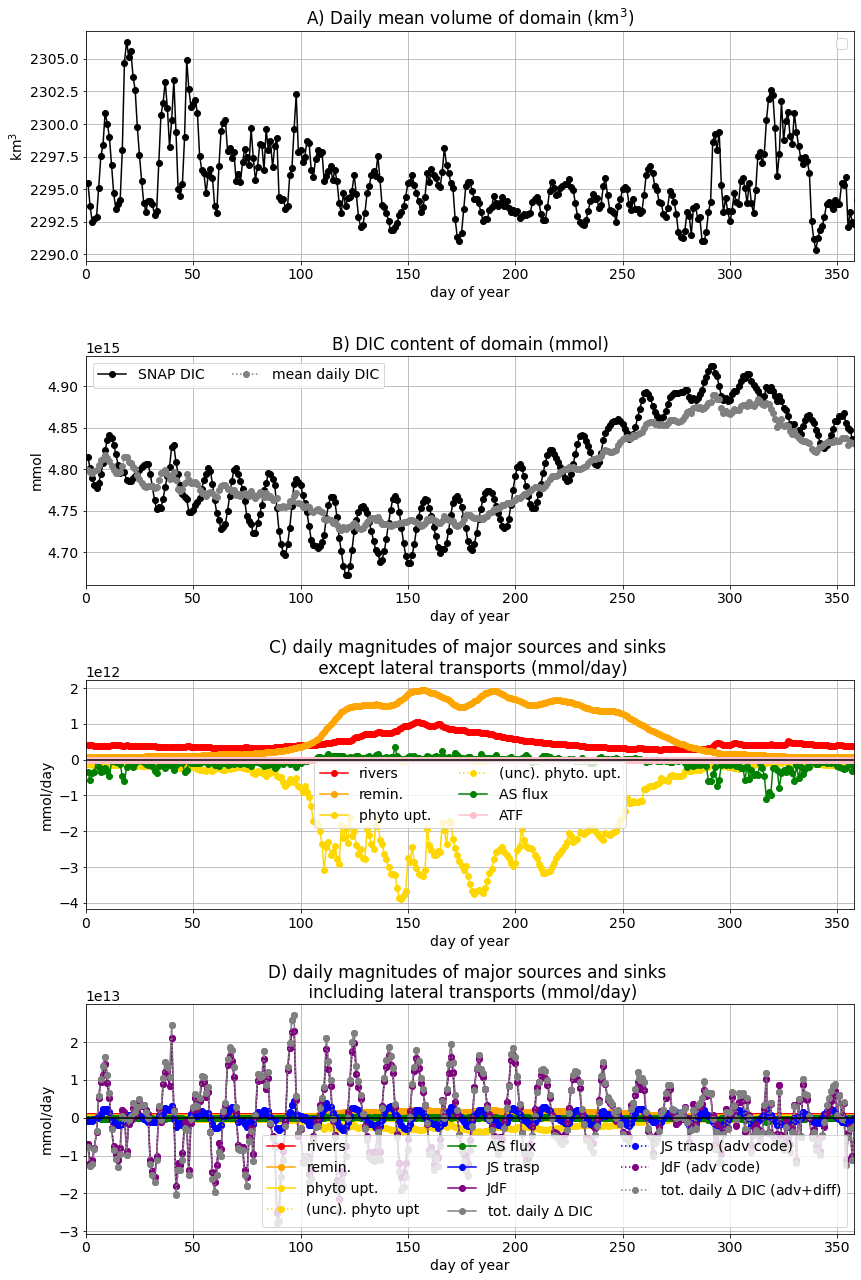

In [31]:

#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 15}

#VARIABLES
# vol_km3_tot_ar ; DIC_mmol_tot_ar 
# DIC_SNAP_mmol_tot_ar ; 
# riv_DIC_mmol_day_tot_ar ; PRD_DIC_mmol_day_tot_ar ; 
# UNC_DIC_mmol_day_tot_ar ; REM_DIC_mmol_day_tot_ar ; 
# DIC_UT_mmol_day_tot_ar ; DIC_VT_mmol_day_tot_ar ; 
# ASflux_mmol_day_tot_ar ; daychange_mmol_day_tot_ar 
#end = '2017-03-01'
w = nc.Dataset(f'BUDGETVARS_RIVTA5_{start}-{end}.nc')
w2 = nc.Dataset(f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc')
#w = nc.Dataset('BUDGETVARS_RIVTA5_2017-01-01-2017-03-01.nc')
# print(w)

## plotting
fact = 0.6
fig, axs = plt.subplots(4,1, figsize=(20*fact, 30*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
\
axs[0].plot(np.arange(1, dayslen+1,1),w['vol_km3_tot_ar'][:], color = 'k',linestyle = '-',  marker = 'o')
axs
axs[1].plot(np.arange(1, dayslen+1,1),w['DIC_SNAP_mmol_tot_ar'][:], color = 'k',linestyle = '-', marker = 'o', \
           label = 'SNAP DIC')
axs[1].plot(np.arange(1, dayslen+1,1),w['DIC_mmol_tot_ar'][:], color = 'grey',linestyle = ':', marker = 'o',\
             label = 'mean daily DIC')
#plot one to one line

axs[2].plot(np.arange(1, dayslen+1,1),w['riv_DIC_mmol_day_tot_ar'][:], color = 'r',linestyle = '-', marker = 'o', \
           label = 'rivers')

axs[2].plot(np.arange(1, dayslen+1,1),w['REM_DIC_mmol_day_tot_ar'][:], color = 'orange',linestyle = '-', marker = 'o', \
           label = 'remin.')

axs[2].plot(np.arange(1, dayslen+1,1),w['PRD_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = '-', marker = 'o', \
           label = 'phyto upt.')
axs[2].plot(np.arange(1, dayslen+1,1),w['UNC_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = ':', marker = 'o', \
           label = '(unc). phyto. upt.')

axs[2].plot(np.arange(1, dayslen+1,1),w['ASflux_mmol_day_tot_ar'][:], color = 'green',linestyle = '-', marker = 'o', \
           label = 'AS flux')

axs[2].plot(np.arange(1, dayslen+1,1),w2['DIC_ATF_mmol_day_tot_ar'][:], color = 'pink',linestyle = '-', marker = 'o', \
           label = 'ATF')

axs[2].axhline(y = 0, color = 'k')

# plt.yscale("log")
###
axs[3].plot(np.arange(1, dayslen+1,1),w['riv_DIC_mmol_day_tot_ar'][:], color = 'r',linestyle = '-', marker = 'o', \
           label = 'rivers')

axs[3].plot(np.arange(1, dayslen+1,1),w['REM_DIC_mmol_day_tot_ar'][:], color = 'orange',linestyle = '-', marker = 'o', \
           label = 'remin.')

axs[3].plot(np.arange(1, dayslen+1,1),w['PRD_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = '-', marker = 'o', \
           label = 'phyto upt.')
axs[3].plot(np.arange(1, dayslen+1,1),w['UNC_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = ':', marker = 'o', \
           label = '(unc). phyto upt')

axs[3].plot(np.arange(1, dayslen+1,1),w['ASflux_mmol_day_tot_ar'][:], color = 'green',linestyle = '-', marker = 'o', \
           label = 'AS flux ')

axs[3].plot(np.arange(1, dayslen+1,1),w['DIC_VT_mmol_day_tot_ar'][:], color = 'blue',linestyle = '-', marker = 'o', \
           label = 'JS trasp')

axs[3].plot(np.arange(1, dayslen+1,1),w['DIC_UT_mmol_day_tot_ar'][:], color = 'purple',linestyle = '-', marker = 'o', \
           label = 'JdF')

axs[3].plot(np.arange(1, dayslen+1,1),w['daychange_mmol_day_tot_ar'][:], color = 'grey',linestyle = '-', marker = 'o', \
           label = 'tot. daily $\Delta$ DIC')


axs[3].plot(np.arange(1, dayslen+1,1),w2['DIC_ATY_mmol_day_pos_ar'][:] + w2['DIC_ATY_mmol_day_neg_ar'][:], color = 'blue',linestyle = ':', marker = 'o', \
           label = 'JS trasp (adv code)')

axs[3].plot(np.arange(1, dayslen+1,1),w2['DIC_ATX_mmol_day_pos_ar'][:] + w2['DIC_ATX_mmol_day_neg_ar'][:], color = 'purple',linestyle = ':', marker = 'o', \
           label = 'JdF (adv code)')

axs[3].plot(np.arange(1, dayslen+1,1),w2['daychange_mmol_day_tot_ar'][:], color = 'grey',linestyle = ':', marker = 'o', \
           label = 'tot. daily $\Delta$ DIC (adv+diff)')

axs[0].set_title('A) Daily mean volume of domain (km$^3$)'); 
axs[1].set_title('B) DIC content of domain (mmol)'); 
axs[2].set_title('C) daily magnitudes of major sources and sinks \n except lateral transports (mmol/day)'); 
axs[3].set_title('D) daily magnitudes of major sources and sinks \n including lateral transports (mmol/day)'); 

axs[0].set_ylabel('km$^3$'); 
axs[1].set_ylabel('mmol'); 
axs[2].set_ylabel('mmol/day'); 
axs[3].set_ylabel('mmol/day'); 


axs[3].axhline(y = 0, color = 'k')
for i in range(0,4):
    axs[i].grid()
    
    axs[i].set_xlim([0,dayslen-1])
    axs[i].set_xlabel('day of year')
    axs[i].legend(loc = 'best', ncol = 2)
    
axs[3].legend(loc = 'best', ncol = 3)
#axs[2].legend(loc = 'best')
#axs[3].legend(bbox_to_anchor = [1 , 1 ], fontsize = 14, ncol = 1)
plt.tight_layout()

No handles with labels found to put in legend.


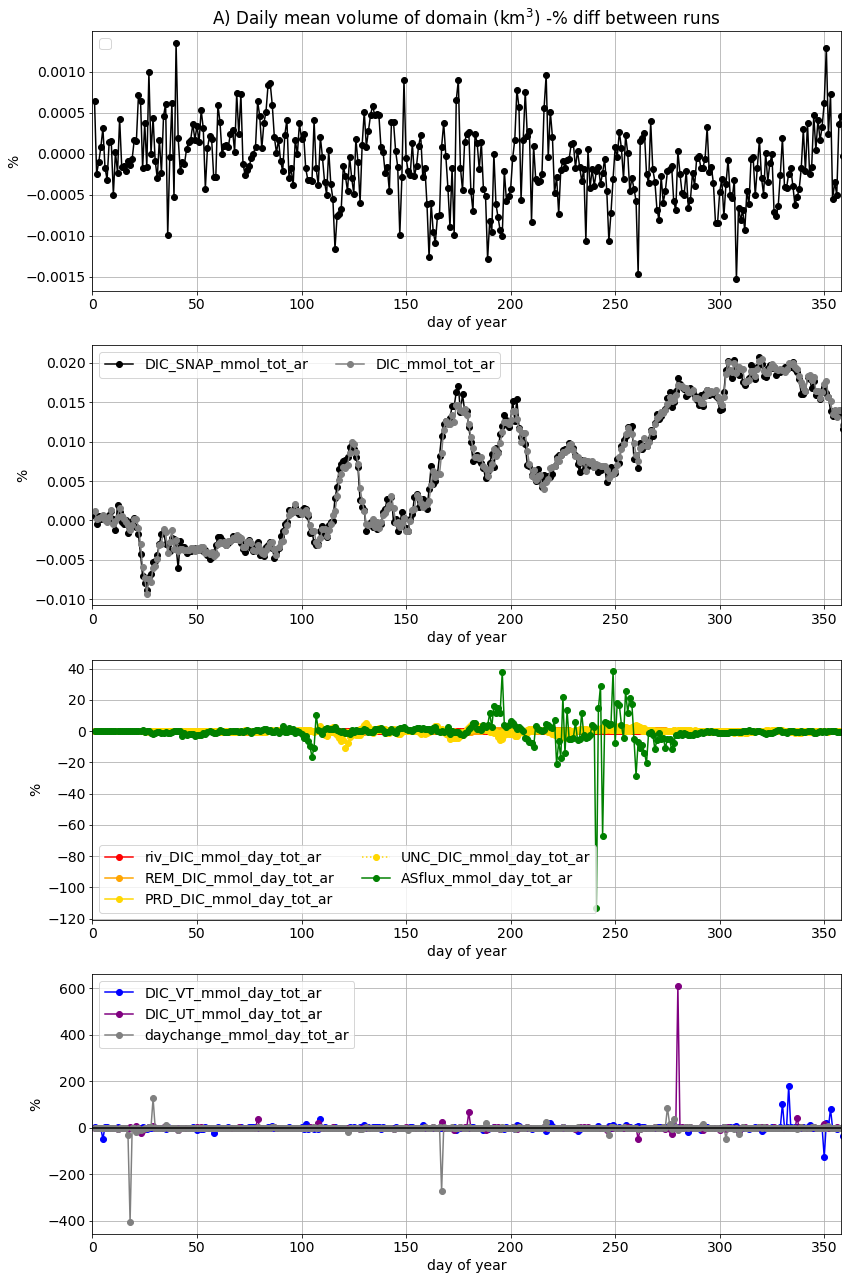

In [32]:

#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 15}

#VARIABLES
# vol_km3_tot_ar ; DIC_mmol_tot_ar 
# DIC_SNAP_mmol_tot_ar ; 
# riv_DIC_mmol_day_tot_ar ; PRD_DIC_mmol_day_tot_ar ; 
# UNC_DIC_mmol_day_tot_ar ; REM_DIC_mmol_day_tot_ar ; 
# DIC_UT_mmol_day_tot_ar ; DIC_VT_mmol_day_tot_ar ; 
# ASflux_mmol_day_tot_ar ; daychange_mmol_day_tot_ar 
#end = '2017-03-01'
w = nc.Dataset(f'BUDGETVARS_RIVTA5_{start}-{end}.nc')
w2 = nc.Dataset(f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc')
#w = nc.Dataset('BUDGETVARS_RIVTA5_2017-01-01-2017-03-01.nc')
# print(w)

## plotting
fact = 0.6
fig, axs = plt.subplots(4,1, figsize=(20*fact, 30*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
\
tthing = 'vol_km3_tot_ar'
axs[0].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'k',linestyle = '-',  marker = 'o')
tthing = 'DIC_SNAP_mmol_tot_ar'
axs[1].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'k',linestyle = '-',  marker = 'o', label = tthing)
tthing = 'DIC_mmol_tot_ar'
axs[1].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'grey',linestyle = '-',  marker = 'o', label = tthing)

tthing = 'riv_DIC_mmol_day_tot_ar'
axs[2].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'r',linestyle = '-',  marker = 'o', label = tthing)

tthing = 'REM_DIC_mmol_day_tot_ar'
axs[2].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'orange',linestyle = '-',  marker = 'o', label = tthing)

tthing = 'PRD_DIC_mmol_day_tot_ar'
axs[2].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'gold',linestyle = '-',  marker = 'o', label = tthing)

tthing = 'UNC_DIC_mmol_day_tot_ar'
axs[2].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'gold',linestyle = ':',  marker = 'o', label = tthing)
tthing = 'ASflux_mmol_day_tot_ar'
axs[2].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'green',linestyle = '-',  marker = 'o', label = tthing)

tthing = 'DIC_VT_mmol_day_tot_ar'
axs[3].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'blue',linestyle = '-',  marker = 'o', label = tthing)
tthing = 'DIC_UT_mmol_day_tot_ar'
axs[3].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'purple',linestyle = '-',  marker = 'o', label = tthing)
tthing = 'daychange_mmol_day_tot_ar'
axs[3].plot(np.arange(1, dayslen+1,1),(w[tthing][:]-w2[tthing][:])/w[tthing][:]*100\
            , color = 'grey',linestyle = '-',  marker = 'o', label = tthing)


axs[0].set_title('A) Daily mean volume of domain (km$^3$) -% diff between runs'); 
# axs[1].set_title('B) DIC content of domain (mmol)'); 
# axs[2].set_title('C) daily magnitudes of major sources and sinks \n except lateral transports (mmol/day)'); 
# axs[3].set_title('D) daily magnitudes of major sources and sinks \n including lateral transports (mmol/day)'); 

axs[0].set_ylabel('%'); 
axs[1].set_ylabel('%'); 
axs[2].set_ylabel('%'); 
axs[3].set_ylabel('%'); 


axs[3].axhline(y = 0, color = 'k')
for i in range(0,4):
    axs[i].grid()
    
    axs[i].set_xlim([0,dayslen-1])
    axs[i].set_xlabel('day of year')
    axs[i].legend(loc = 'best', ncol = 2)
    
axs[3].legend(loc = 'best', ncol = 1)
#axs[2].legend(loc = 'best')
#axs[3].legend(bbox_to_anchor = [1 , 1 ], fontsize = 14, ncol = 1)
plt.tight_layout()

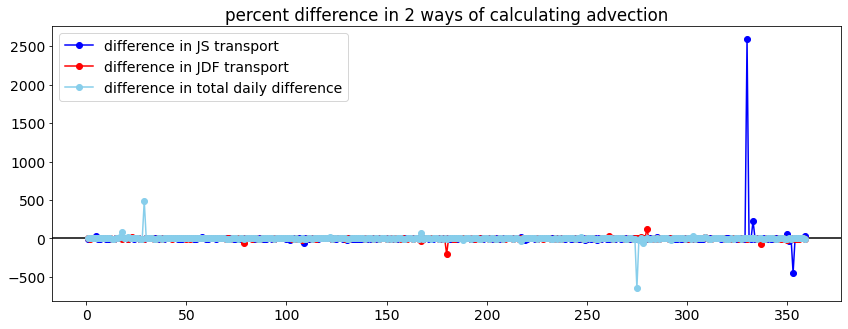

In [33]:
#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 15}

#VARIABLES
# vol_km3_tot_ar ; DIC_mmol_tot_ar 
# DIC_SNAP_mmol_tot_ar ; 
# riv_DIC_mmol_day_tot_ar ; PRD_DIC_mmol_day_tot_ar ; 
# UNC_DIC_mmol_day_tot_ar ; REM_DIC_mmol_day_tot_ar ; 
# DIC_UT_mmol_day_tot_ar ; DIC_VT_mmol_day_tot_ar ; 
# ASflux_mmol_day_tot_ar ; daychange_mmol_day_tot_ar 
#end = '2017-03-01'
w = nc.Dataset(f'BUDGETVARS_RIVTA5_{start}-{end}.nc')
w2 = nc.Dataset(f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc')
#w = nc.Dataset('BUDGETVARS_RIVTA5_2017-01-01-2017-03-01.nc')
# print(w)

## plotting
fact = 0.6
fig, axs = plt.subplots(1,1, figsize=(20*fact, 8*fact), facecolor='w', edgecolor='k')

axs.axhline(y = 0, color = 'k')

VT = w['DIC_VT_mmol_day_tot_ar'][:]
Yadv = w2['DIC_ATY_mmol_day_pos_ar'][:]+w2['DIC_ATY_mmol_day_neg_ar'][:]


UT = w['DIC_UT_mmol_day_tot_ar'][:]
Xadv = w2['DIC_ATX_mmol_day_pos_ar'][:]+w2['DIC_ATX_mmol_day_neg_ar'][:]

axs.plot(np.arange(1, dayslen+1,1),((Yadv-VT)/Yadv) *100, color = 'blue',linestyle = '-', marker = 'o', \
           label = 'difference in JS transport')
axs.plot(np.arange(1, dayslen+1,1),((Xadv-UT)/Xadv) *100, color = 'red',linestyle = '-', marker = 'o', \
           label = 'difference in JDF transport')

old_daychange = w['daychange_mmol_day_tot_ar'][:]
new_daychange = w2['daychange_mmol_day_tot_ar'][:]

axs.plot(np.arange(1, dayslen+1,1),((new_daychange-old_daychange)/new_daychange) *100, color = 'skyblue',linestyle = '-', marker = 'o', \
           label = 'difference in total daily difference')
axs.legend()
axs.set_title('percent difference in 2 ways of calculating advection')
plt.tight_layout()

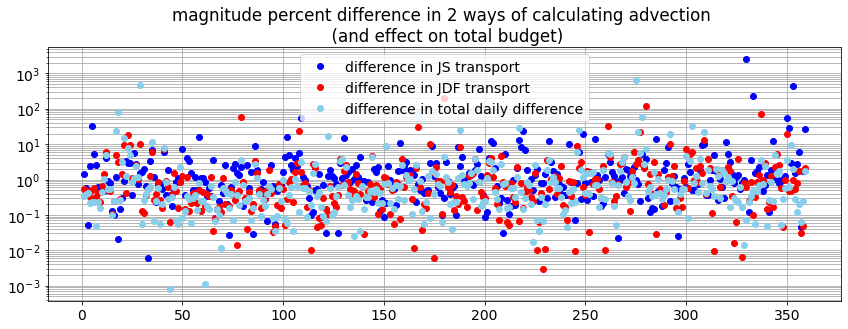

In [34]:
#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 15}

#VARIABLES
# vol_km3_tot_ar ; DIC_mmol_tot_ar 
# DIC_SNAP_mmol_tot_ar ; 
# riv_DIC_mmol_day_tot_ar ; PRD_DIC_mmol_day_tot_ar ; 
# UNC_DIC_mmol_day_tot_ar ; REM_DIC_mmol_day_tot_ar ; 
# DIC_UT_mmol_day_tot_ar ; DIC_VT_mmol_day_tot_ar ; 
# ASflux_mmol_day_tot_ar ; daychange_mmol_day_tot_ar 
#end = '2017-03-01'
w = nc.Dataset(f'BUDGETVARS_RIVTA5_{start}-{end}.nc')
w2 = nc.Dataset(f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc')
#w = nc.Dataset('BUDGETVARS_RIVTA5_2017-01-01-2017-03-01.nc')
# print(w)

## plotting
fact = 0.6
fig, axs = plt.subplots(1,1, figsize=(20*fact, 8*fact), facecolor='w', edgecolor='k')

axs.axhline(y = 0, color = 'k')

VT = w['DIC_VT_mmol_day_tot_ar'][:]
Yadv = w2['DIC_ATY_mmol_day_pos_ar'][:]+w2['DIC_ATY_mmol_day_neg_ar'][:]


UT = w['DIC_UT_mmol_day_tot_ar'][:]
Xadv = w2['DIC_ATX_mmol_day_pos_ar'][:]+w2['DIC_ATX_mmol_day_neg_ar'][:]

axs.plot(np.arange(1, dayslen+1,1),np.abs((Yadv-VT)/Yadv) *100, color = 'blue',linestyle = '', marker = 'o', \
           label = 'difference in JS transport')
axs.plot(np.arange(1, dayslen+1,1),np.abs((Xadv-UT)/Xadv) *100, color = 'red',linestyle = '', marker = 'o', \
           label = 'difference in JDF transport')

old_daychange = w['daychange_mmol_day_tot_ar'][:]
new_daychange = w2['daychange_mmol_day_tot_ar'][:]

axs.plot(np.arange(1, dayslen+1,1),np.abs((new_daychange-old_daychange)/new_daychange) *100, color = 'skyblue',linestyle = '', marker = 'o', \
           label = 'difference in total daily difference')
axs.legend()

plt.yscale('log')
plt.grid(b=True, which='both', color='0.65', linestyle='-')
axs.set_title('magnitude percent difference in 2 ways of calculating advection \n (and effect on total budget)')
plt.tight_layout()

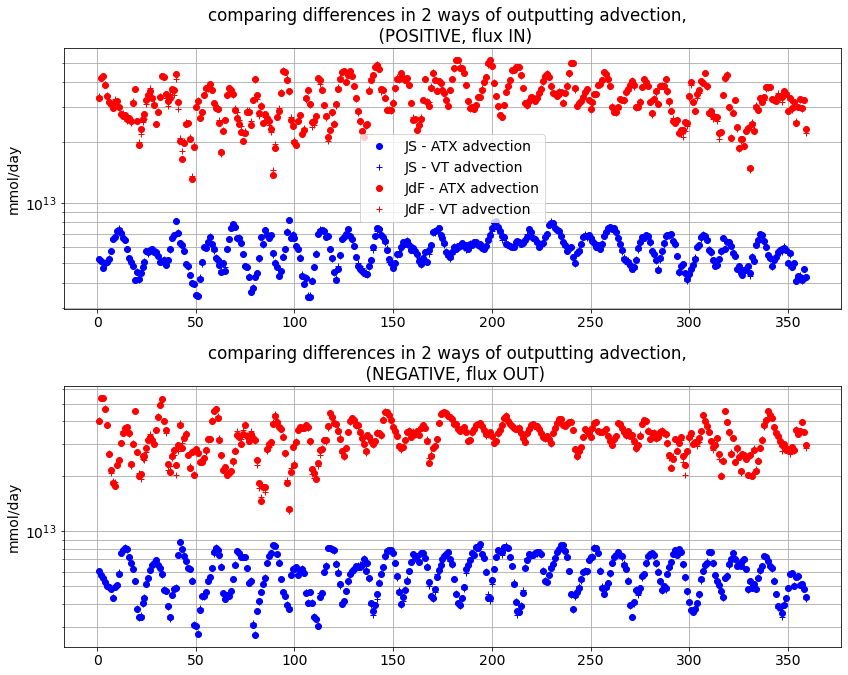

In [35]:
#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 15}

#VARIABLES
# vol_km3_tot_ar ; DIC_mmol_tot_ar 
# DIC_SNAP_mmol_tot_ar ; 
# riv_DIC_mmol_day_tot_ar ; PRD_DIC_mmol_day_tot_ar ; 
# UNC_DIC_mmol_day_tot_ar ; REM_DIC_mmol_day_tot_ar ; 
# DIC_UT_mmol_day_tot_ar ; DIC_VT_mmol_day_tot_ar ; 
# ASflux_mmol_day_tot_ar ; daychange_mmol_day_tot_ar 
#end = '2017-03-01'
w = nc.Dataset(f'BUDGETVARS_RIVTA5_{start}-{end}.nc')
w2 = nc.Dataset(f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc')
#w = nc.Dataset('BUDGETVARS_RIVTA5_2017-01-01-2017-03-01.nc')
# print(w)

## plotting
fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(20*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

VT = w['DIC_VT_mmol_day_pos_ar'][:]
Yadv = w2['DIC_ATY_mmol_day_pos_ar'][:]

UT = w['DIC_UT_mmol_day_pos_ar'][:]
Xadv = w2['DIC_ATX_mmol_day_pos_ar'][:]

axs[0].plot(np.arange(1, dayslen+1,1),Yadv, color = 'blue',linestyle = '', marker = 'o', \
           label = 'JS - ATX advection')
axs[0].plot(np.arange(1, dayslen+1,1),VT, color = 'blue',linestyle = '',  marker = '+', \
           label = 'JS - VT advection')
axs[0].plot(np.arange(1, dayslen+1,1),Xadv, color = 'red',linestyle = '', marker = 'o',  \
           label = 'JdF - ATX advection')
axs[0].plot(np.arange(1, dayslen+1,1),UT, color = 'red',linestyle = '',  marker = '+', \
           label = 'JdF - VT advection')

VT = w['DIC_VT_mmol_day_neg_ar'][:]
Yadv = w2['DIC_ATY_mmol_day_neg_ar'][:]

UT = w['DIC_UT_mmol_day_neg_ar'][:]
Xadv = w2['DIC_ATX_mmol_day_neg_ar'][:]

axs[1].plot(np.arange(1, dayslen+1,1),-1*Yadv, color = 'blue',linestyle = '', marker = 'o', \
           label = 'JS - ATX advection')
axs[1].plot(np.arange(1, dayslen+1,1),-1*VT, color = 'blue',linestyle = '',  marker = '+', \
           label = 'JS - VT advection')
axs[1].plot(np.arange(1, dayslen+1,1),-1*Xadv, color = 'red',linestyle = '', marker = 'o',  \
           label = 'JdF - ATX advection')
axs[1].plot(np.arange(1, dayslen+1,1),-1*UT, color = 'red',linestyle = '',  marker = '+', \
           label = 'JdF - VT advection')


# axs[1].plot(np.arange(1, dayslen+1,1),-1*Yadv, color = 'blue',linestyle = '', marker = 'o', \
#            label = 'JS - ATX advection')
# axs[1].plot(np.arange(1, dayslen+1,1),-1*VT, color = 'blue',linestyle = '',  marker = '+', \
#            label = 'JS - VT advection')
# axs[1].plot(np.arange(1, dayslen+1,1),-1*Xadv, color = 'red',linestyle = '', marker = 'o',  \
#            label = 'JdF - ATX advection')
# axs[1].plot(np.arange(1, dayslen+1,1),-1*UT, color = 'red',linestyle = '',  marker = '+', \
#            label = 'JdF - VT advection')

# old_daychange = w['daychange_mmol_day_tot_ar'][:]
# new_daychange = w2['daychange_mmol_day_tot_ar'][:]

# axs.plot(np.arange(1, dayslen+1,1),np.abs((new_daychange-old_daychange)/new_daychange) *100, color = 'skyblue',linestyle = '', marker = 'o', \
#            label = 'difference in total daily difference')
# axs.legend()

axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].legend()
axs[0].grid(b=True, which='both', color='0.65', linestyle='-')
axs[1].grid(b=True, which='both', color='0.65', linestyle='-')
axs[0].set_ylabel('mmol/day'); axs[1].set_ylabel('mmol/day')
axs[0].set_title('comparing differences in 2 ways of outputting advection,  \n (POSITIVE, flux IN)')
axs[1].set_title('comparing differences in 2 ways of outputting advection,  \n (NEGATIVE, flux OUT)')
plt.tight_layout()

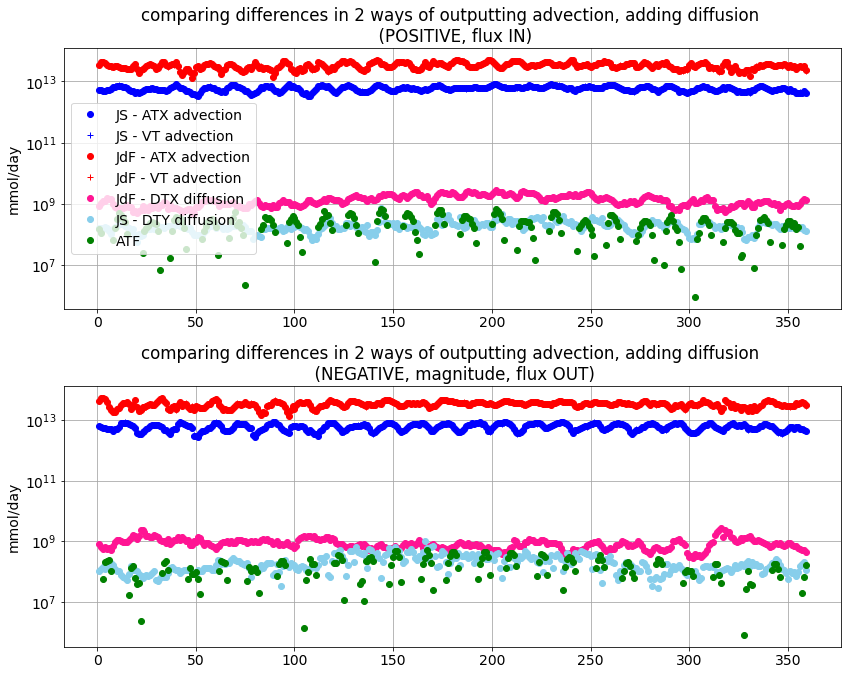

In [36]:
dayslen = 359
#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 15}

#VARIABLES
# vol_km3_tot_ar ; DIC_mmol_tot_ar 
# DIC_SNAP_mmol_tot_ar ; 
# riv_DIC_mmol_day_tot_ar ; PRD_DIC_mmol_day_tot_ar ; 
# UNC_DIC_mmol_day_tot_ar ; REM_DIC_mmol_day_tot_ar ; 
# DIC_UT_mmol_day_tot_ar ; DIC_VT_mmol_day_tot_ar ; 
# ASflux_mmol_day_tot_ar ; daychange_mmol_day_tot_ar 
#end = '2017-03-01'
w = nc.Dataset(f'BUDGETVARS_RIVTA5_{start}-{end}.nc')
w2 = nc.Dataset(f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc')
#w = nc.Dataset('BUDGETVARS_RIVTA5_2017-01-01-2017-03-01.nc')
# print(w)

## plotting
fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(20*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

VT = w['DIC_VT_mmol_day_pos_ar'][:]
Yadv = w2['DIC_ATY_mmol_day_pos_ar'][:]

UT = w['DIC_UT_mmol_day_pos_ar'][:]
Xadv = w2['DIC_ATX_mmol_day_pos_ar'][:]

Ydif = w2['DIC_DTY_mmol_day_pos_ar'][:]
Xdif = w2['DIC_DTX_mmol_day_pos_ar'][:]

axs[0].plot(np.arange(1, dayslen+1,1),Yadv, color = 'blue',linestyle = '', marker = 'o', \
           label = 'JS - ATX advection')
axs[0].plot(np.arange(1, dayslen+1,1),VT, color = 'blue',linestyle = '',  marker = '+', \
           label = 'JS - VT advection')
axs[0].plot(np.arange(1, dayslen+1,1),Xadv, color = 'red',linestyle = '', marker = 'o',  \
           label = 'JdF - ATX advection')
axs[0].plot(np.arange(1, dayslen+1,1),UT, color = 'red',linestyle = '',  marker = '+', \
           label = 'JdF - VT advection')
axs[0].plot(np.arange(1, dayslen+1,1),Xdif, color = 'deeppink',linestyle = '', marker = 'o',  \
           label = 'JdF - DTX diffusion')
axs[0].plot(np.arange(1, dayslen+1,1),Ydif, color = 'skyblue',linestyle = '', marker = 'o',  \
           label = 'JS - DTY diffusion')
axs[0].plot(np.arange(1, dayslen+1,1),w2['DIC_ATF_mmol_day_tot_ar'][:], color = 'green',linestyle = '', marker = 'o', \
           label = 'ATF')


VT = w['DIC_VT_mmol_day_neg_ar'][:]
Yadv = w2['DIC_ATY_mmol_day_neg_ar'][:]

UT = w['DIC_UT_mmol_day_neg_ar'][:]
Xadv = w2['DIC_ATX_mmol_day_neg_ar'][:]

Ydif = w2['DIC_DTY_mmol_day_neg_ar'][:]
Xdif = w2['DIC_DTX_mmol_day_neg_ar'][:]

axs[1].plot(np.arange(1, dayslen+1,1),-1*Yadv, color = 'blue',linestyle = '', marker = 'o', \
           label = 'JS - ATX advection')
axs[1].plot(np.arange(1, dayslen+1,1),-1*VT, color = 'blue',linestyle = '',  marker = '+', \
           label = 'JS - VT advection')
axs[1].plot(np.arange(1, dayslen+1,1),-1*Xadv, color = 'red',linestyle = '', marker = 'o',  \
           label = 'JdF - ATX advection')
axs[1].plot(np.arange(1, dayslen+1,1),-1*UT, color = 'red',linestyle = '',  marker = '+', \
           label = 'JdF - VT advection')

axs[1].plot(np.arange(1, dayslen+1,1),-1*Xdif, color = 'deeppink',linestyle = '', marker = 'o',  \
           label = 'JdF - DTX diffusion')
axs[1].plot(np.arange(1, dayslen+1,1),-1*Ydif, color = 'skyblue',linestyle = '', marker = 'o',  \
           label = 'JS - DTY diffusion')

axs[1].plot(np.arange(1, dayslen+1,1),-1*w2['DIC_ATF_mmol_day_tot_ar'][:], color = 'green',linestyle = '', marker = 'o', \
           label = 'ATF')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].legend()
axs[0].grid(b=True, which='both', color='0.65', linestyle='-')
axs[1].grid(b=True, which='both', color='0.65', linestyle='-')

axs[0].set_title('comparing differences in 2 ways of outputting advection, adding diffusion \n (POSITIVE, flux IN)')
axs[1].set_title('comparing differences in 2 ways of outputting advection, adding diffusion \n (NEGATIVE, magnitude, flux OUT)')

axs[0].set_ylabel('mmol/day'); axs[1].set_ylabel('mmol/day')

plt.tight_layout()

In [37]:
daily_diff = w['daychange_mmol_day_tot_ar'][:]
daily_SNAP = w['DIC_SNAP_mmol_tot_ar'][:]

print(np.shape(daily_diff))

SNAP_diff = np.zeros_like(daily_SNAP)
day1_SNAP_plus_cum_diff = np.zeros_like(daily_diff)


day1_SNAP_plus_cum_diff[0] = daily_SNAP[0]

for i in range(1,dayslen):
    
    day1_SNAP_plus_cum_diff[i] = \
    day1_SNAP_plus_cum_diff[0] + np.nansum(daily_diff[1:i+1])
    
day1_SNAP_plus_cum_diff[day1_SNAP_plus_cum_diff == 0 ] = np.nan


for i in range(1,dayslen):
    SNAP_diff[i] = daily_SNAP[i] - daily_SNAP[i-1]
    
SNAP_diff[0] = np.nan

print(np.shape(SNAP_diff))
print(dayslen)




(359,)
(359,)
359


In [38]:
daily_diff_NB = w2['daychange_mmol_day_tot_ar'][:]
daily_SNAP_NB = w2['DIC_SNAP_mmol_tot_ar'][:]


SNAP_diff_NB = np.zeros_like(daily_SNAP_NB)
day1_SNAP_plus_cum_diff_NB = np.zeros_like(daily_diff_NB)


day1_SNAP_plus_cum_diff_NB[0] = daily_SNAP_NB[0]

for i in range(1,dayslen):
    
    day1_SNAP_plus_cum_diff_NB[i] = \
    day1_SNAP_plus_cum_diff_NB[0] + np.nansum(daily_diff_NB[1:i+1])
    
day1_SNAP_plus_cum_diff_NB[day1_SNAP_plus_cum_diff_NB == 0 ] = np.nan


for i in range(1,dayslen):
    SNAP_diff_NB[i] = daily_SNAP_NB[i] - daily_SNAP_NB[i-1]
    
SNAP_diff_NB[0] = np.nan

print(np.shape(SNAP_diff_NB))
print(dayslen)


(359,)
359


In [39]:
daily_diff_NB_new = w2['daychange_new_mmol_day_tot_ar'][:]
daily_SNAP_NB = w2['DIC_SNAP_mmol_tot_ar'][:]


#SNAP_diff_NB_new = np.zeros_like(daily_SNAP_NB)
day1_SNAP_plus_cum_diff_NB_new = np.zeros_like(daily_diff_NB)


day1_SNAP_plus_cum_diff_NB_new[0] = daily_SNAP_NB[0]

for i in range(1,dayslen):
    
    day1_SNAP_plus_cum_diff_NB_new[i] = \
    day1_SNAP_plus_cum_diff_NB_new[0] + np.nansum(daily_diff_NB_new[1:i+1])
    
day1_SNAP_plus_cum_diff_NB_new[day1_SNAP_plus_cum_diff_NB_new == 0 ] = np.nan


for i in range(1,dayslen):
    SNAP_diff_NB[i] = daily_SNAP_NB[i] - daily_SNAP_NB[i-1]
    
SNAP_diff_NB[0] = np.nan

print(np.shape(SNAP_diff_NB))
print(dayslen)


(359,)
359


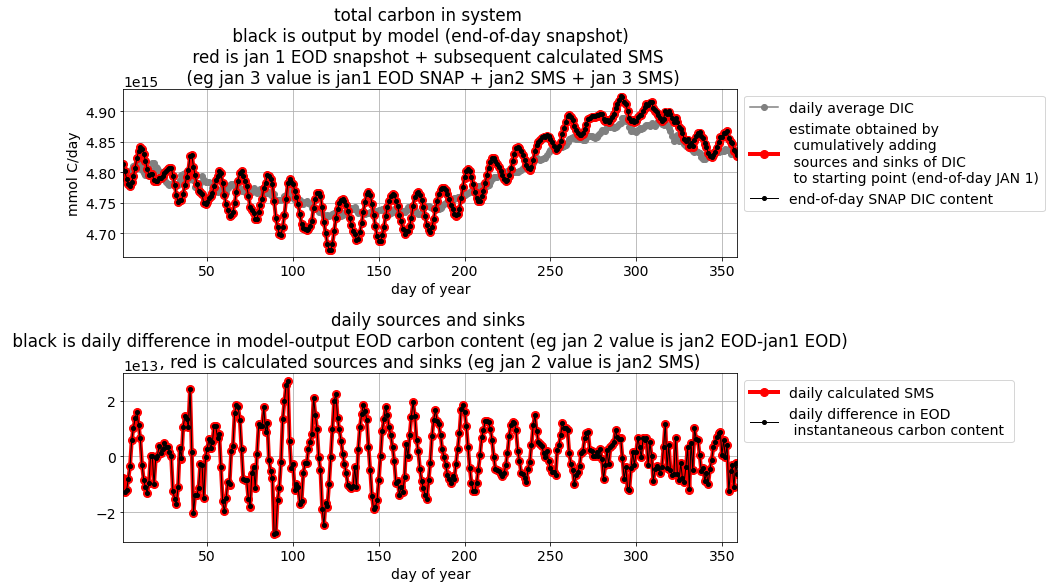

In [40]:
fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(np.arange(1,dayslen+1,1),w['DIC_mmol_tot_ar'][:], color = 'grey',linestyle = '-',  marker = 'o', \
           label = 'daily average DIC ')

axs[0].plot(np.arange(1,dayslen+1,1),day1_SNAP_plus_cum_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, \
           label = 'estimate obtained by \n cumulatively adding \n sources and sinks of DIC \n to starting point (end-of-day JAN 1)')
axs[0].plot(np.arange(1,dayslen+1,1),w['DIC_SNAP_mmol_tot_ar'][:], color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4,\
           label = 'end-of-day SNAP DIC content')
axs[0].legend(bbox_to_anchor = [1, 1])


axs[1].plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
axs[1].plot(np.arange(1,dayslen+1,1),SNAP_diff, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')

axs[0].set_title('total carbon in system \n black is output by model (end-of-day snapshot) \n red is jan 1 EOD snapshot + subsequent calculated SMS  \n (eg jan 3 value is jan1 EOD SNAP + jan2 SMS + jan 3 SMS)')
axs[1].set_title('daily sources and sinks \n black is daily difference in model-output EOD carbon content (eg jan 2 value is jan2 EOD-jan1 EOD) \n , red is calculated sources and sinks (eg jan 2 value is jan2 SMS) ')
axs[0].set_ylabel('mmol C')
axs[0].set_ylabel('mmol C/day')

for i in range(0,2):
    axs[i].grid();
    axs[i].set_xlabel('day of year')
    axs[i].set_xlim([1,dayslen])
    axs[i].legend(bbox_to_anchor = [1 ,1])
plt.tight_layout()


####  Visually these estimates seem to line up very well; quantitatively, how close are they?

Let's look at the percent difference in the total carbon content calculated 2 ways, and also at the percent difference in implied SMS (difference in EOD reported values by E3TSNAP from day to day) and the calculated daily SMS. 

The total difference in the total carbon content calculated 2 ways is small (order 1/100 of a %) but potentially increasing. 
  

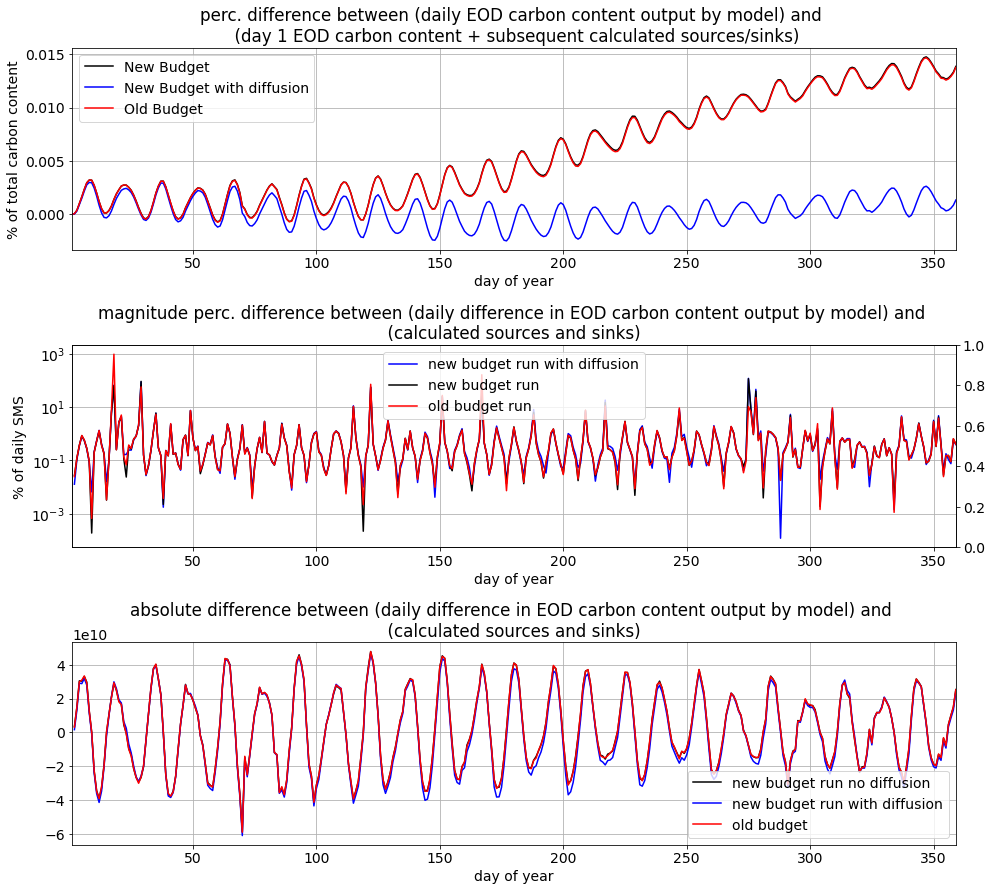

In [41]:
fact = 0.7
fig, axs = plt.subplots(3,1, figsize=(20*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

SNAPest = w['DIC_SNAP_mmol_tot_ar'][:]
SMSest = day1_SNAP_plus_cum_diff

SNAPest_NB = w2['DIC_SNAP_mmol_tot_ar'][:]
SMSest_NB = day1_SNAP_plus_cum_diff_NB
SMSest_NB_new = day1_SNAP_plus_cum_diff_NB_new


axs[0].plot(np.arange(1,dayslen+1,1), \
            (((SNAPest_NB)-(SMSest_NB)))/((SNAPest_NB+SMSest_NB)/2) *100, label = 'New Budget', color = 'k')
axs[0].plot(np.arange(1,dayslen+1,1), \
            (((SNAPest_NB)-(SMSest_NB_new)))/((SNAPest_NB+SMSest_NB_new)/2) *100, label = 'New Budget with diffusion', color = 'b')

axs[0].plot(np.arange(1,dayslen+1,1), (((SNAPest)-(SMSest)))/((SNAPest+SMSest)/2) *100, label = 'Old Budget', color = 'r')

SNAPest_NB = SNAP_diff_NB
SMSest_NB = daily_diff_NB
SMSest_NB_new = daily_diff_NB_new

axs[1].plot(np.arange(1,dayslen+1,1), np.abs((SNAPest_NB-SMSest_NB_new)/((SNAPest_NB+SMSest_NB_new)/2)) *100, color = 'b', label = 'new budget run with diffusion')
axs[1].plot(np.arange(1,dayslen+1,1), np.abs((SNAPest_NB-SMSest_NB)/((SNAPest_NB+SMSest_NB)/2)) *100, color = 'k', label = 'new budget run')

#axs[1].plot(np.arange(1,dayslen+1,1), np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2) *100)

SNAPest = SNAP_diff
SMSest = daily_diff

axs[1].plot(np.arange(1,dayslen+1,1), np.abs((SNAPest-SMSest)/((SNAPest+SMSest)/2)) *100, color = 'r', label = 'old budget run')
axs[1].set_yscale('log')
#


ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis


axs[2].plot(np.arange(1,dayslen+1,1), SNAPest_NB-SMSest_NB, color = 'k', label = 'new budget run no diffusion')
axs[2].plot(np.arange(1,dayslen+1,1), SNAPest_NB-SMSest_NB_new, color = 'b', label = 'new budget run with diffusion')
axs[2].plot(np.arange(1,dayslen+1,1), SNAPest-SMSest, color = 'r', label = 'old budget')

# axs[2].plot(np.arange(1,dayslen+1,1), daily_diff_NB_new-  color = 'b', label = 'new budget run with diffusion')
# axs[2].plot(np.arange(1,dayslen+1,1), np.abs((SNAPest-SMSest)/((SNAPest+SMSest)/2)) *100, color = 'k', label = 'new budget run')

#color = 'tab:blue'
#ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
# ax2.plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
# ax2.plot(np.arange(1,dayslen+1,1),SNAP_diff, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')
# ax2.plot(np.arange(1,dayslen+1,1),daily_diff_NB, color = 'orange',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
# ax2.plot(np.arange(1,dayslen+1,1),SNAP_diff_NB, color = 'grey',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')

# ax2.plot(np.arange(1,dayslen+1,1),np.zeros_like(SNAP_diff), color = 'b')
# ax2.set_ylabel('SMS carbon, mmol/day')
# axs[1].plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
# axs[1].plot(np.arange(1,dayslen+1,1),SNAP_DIFF, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')

axs[0].set_title('perc. difference between (daily EOD carbon content output by model) and \n (day 1 EOD carbon content + subsequent calculated sources/sinks)')
axs[1].set_title('magnitude perc. difference between (daily difference in EOD carbon content output by model) and \n (calculated sources and sinks) ')
axs[0].set_ylabel('% of total carbon content')
axs[1].set_ylabel('% of daily SMS')
axs[2].set_title('absolute difference between (daily difference in EOD carbon content output by model) and \n (calculated sources and sinks) ')


for i in range(0,3):
    axs[i].grid();
    axs[i].set_xlabel('day of year')
    axs[i].set_xlim([1,dayslen])
    axs[i].legend(loc = 'best')
plt.tight_layout()


## So, how close is our budget?

In most cases, the calculated sources and sinks are at least visually quite similar, as we can see. The mean magnitude of teh sources and sinks (mean of abs(SMS)) is ~8.21362108E+12. The large spikes in percent difference (shown above in blue) occur when the net sources and sinks are close to 0 (and sometimes on the opposite sides of 0). Disregarding where |SMS| < 1e12, the mean % difference is 0.987%. The mean difference between the 2 ways of calculating the sources and the sinks, not disregarding small sources and sinks, is 3%.  This is close, but is it close enough?

##daily budget gap is ~1e10


## Could the 'missing flux' be lateral diffusion?

Coefficient of lateral diffusion:
1.5 m2/s

total lateral diffusion (mmol/day) = coeff_ld * ∇ DIC * cross-sectional area * seconds/day



In [42]:

#total lateral diffusion (mmol/day) = 
#coeff_ld * ∇ DIC * cross-sectional area * seconds/day

print('total lateral diffusion (mmol/day) = ')
print('coeff_ld (m2/s) * ∇ DIC (mmol/m3/m) * cross-sectional area (m2) * seconds/day')
print('')
#mmk = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(mmk)
e2t_here = (mmk['e2t'][0,:,20])
e3t_here = (mmk['e3t_0'][0,:,:,20])
tmask_here = mmk['tmask'][0,:,:,20]
e2t_here_broad = np.zeros_like(e3t_here)
for i in range(0,40):
    e2t_here_broad[i,:] = e2t_here

jdf_crossection = (e2t_here_broad*tmask_here*e3t_here)

tot_jdf_cross = (np.nansum(jdf_crossection))


coeff_ld = 1.5

grad_DIC = 10
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))
print()

grad_DIC = 1
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))
print()

grad_DIC = 0.05
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))

print(f'({grad_DIC} umol/m = {grad_DIC*1000} umol/km)')
print()
print('our daily budget gap is ')
(print(f"{Decimal(budgetgap):.8E} mmol/day"))

#total lateral diffusion (mmol/day) = 
#coeff_ld * ∇ DIC * cross-sectional area * seconds/day

total lateral diffusion (mmol/day) = 
coeff_ld (m2/s) * ∇ DIC (mmol/m3/m) * cross-sectional area (m2) * seconds/day

Assuming a DIC gradient of 10 umol/m across the JDF boundary,
our BOE tot. lat diff would be
6.08274530E+12 mmol/day

Assuming a DIC gradient of 1 umol/m across the JDF boundary,
our BOE tot. lat diff would be
6.08274530E+11 mmol/day

Assuming a DIC gradient of 0.05 umol/m across the JDF boundary,
our BOE tot. lat diff would be
3.04137265E+10 mmol/day
(0.05 umol/m = 50.0 umol/km)

our daily budget gap is 


NameError: name 'budgetgap' is not defined

## what is the residence time of our system? 


In [ ]:
tot_in_dom = w['DIC_SNAP_mmol_tot_ar'][:]

print('total mmol in system - mean (mmol)')
print(np.nanmean(tot_in_dom))

print('total transport into system - mean (mmol/day)')
tot_pos = w['DIC_UT_mmol_day_pos_ar'][:]+w['DIC_VT_mmol_day_pos_ar'][:]
print(np.nanmean(tot_pos))

print('total transport out of system - mean (mmol/day)')
tot_neg = w['DIC_UT_mmol_day_neg_ar'][:]+w['DIC_VT_mmol_day_neg_ar'][:]
print(np.nanmean(tot_neg))

print('simple res time based on pos. transp.')
print(np.nanmean(tot_in_dom)/np.nanmean(tot_pos))

print('simple res time based on neg. transp.')
print(np.nanmean(tot_in_dom)/np.nanmean(tot_neg))

In [ ]:
print(w)